In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict, Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

sns.set(font_scale=1.2)


In [4]:
prior=pd.read_csv('data/order_products__prior.csv')

In [5]:
recent_order = pd.read_csv('data/order_products__train.csv')

In [65]:
orders_all = pd.read_csv('data/orders.csv')

Remove Kaggle Test set

In [5]:
kaggle_test = orders_all[orders_all['eval_set']=='test']
kaggle_test.shape

(75000, 7)

In [66]:
orders_all = orders_all[~(orders_all['eval_set']=='test')]
orders_all.shape

(3346083, 7)

In [68]:
with open('pkl/test_users.pkl', 'rb') as f:
    test_user = pickle.load(f)

In [18]:
orders_all.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [69]:
train_recent_order = orders_all[~(orders_all['user_id'].isin(test_user)) & (orders_all['eval_set']=='train')]

In [22]:
test_recent_order = orders_all[(orders_all['user_id'].isin(test_user)) & (orders_all['eval_set']=='train')]

In [23]:
orders_all.shape, train_recent_order.shape, test_recent_order.shape

((3346083, 7), (118977, 7), (12232, 7))

In [25]:
del test_order

In [26]:
with open('pkl/test_order.pkl', 'wb') as f:
    pickle.dump(test_recent_order, f)

In [28]:
test_recent_order.to_csv('data/test_order.csv')

format feature and target

In [30]:
recent_details= pd.merge(recent_order, orders_all.drop(columns='eval_set'), on='order_id', how = 'left')

In [32]:
recent_order_test = recent_details[recent_details.order_id.isin(test_recent_order['order_id'])]
recent_order_train = recent_details[~recent_details.order_id.isin(test_recent_order['order_id'])]
recent_order_train.shape, recent_order_test.shape, recent_details.shape

((1257273, 9), (127344, 9), (1384617, 9))

In [40]:
recent_order_train.to_csv('processing/recent_order_train.csv')

In [41]:
recent_order_test.to_csv('processing/recent_order_test.csv')

In [33]:
recent_order_set = (recent_order_train, recent_order_test)
with open('pkl/test_train_recent_order.pkl', 'wb') as f:
    pickle.dump(recent_order_set, f)

In [6]:
# with open('pkl/test_train_recent_order.pkl', 'rb') as f:
#     recent_order_train, recent_order_test = pickle.load(f)

In [22]:
# with open('pkl/test_train_recent_order.pkl', 'rb') as f:
#     recent_order_train, _ = pickle.load(f)

In [6]:
recent_order_train.shape

(1257273, 9)

In [7]:
recent_order_train.head(1)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,4,4,10,9.0


In [8]:
prior_details = pd.merge(prior, orders_all[orders_all['eval_set']=='prior'], on='order_id', how='right')

In [9]:
prior_summary= prior_details.groupby(['user_id','product_id'], as_index=False).reordered.sum()
prior_summary.rename({'reordered':'user_product_reordered_past'}, axis=1, inplace=True)

In [10]:
prior_summary.head()

,user_id,product_id,user_product_reordered_past
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2


In [11]:
recent_order_train.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,4,4,10,9.0
1,1,11109,2,1,112108,4,4,10,9.0
2,1,10246,3,0,112108,4,4,10,9.0


In [12]:
recent_order_train.shape

(1257273, 9)

Get all the product the user ordered in the past and predict if he will reorder in his recent order. Assign the reordered information (0 or 1) to the prior order (groupby user and product id)

In [19]:
df = prior_summary[prior_summary.user_id.isin(recent_order_train.user_id)]

In [22]:
data_set = (df, prior_summary, prior_details)
with open('processing/0806m.pkl', 'wb') as f:
    pickle.dump(data_set, f)

In [10]:
# with open('processing/0806m.pkl', 'rb') as f:
#     df, prior_summary, prior_details = pickle.load(f)

In [13]:
df = pd.merge(df, recent_order_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [16]:
df.head(1)

,user_id,product_id,user_product_reordered_past,reordered
0,1,196,9,1.0


In [17]:
df['reordered'].fillna(0,inplace=True)

#### Add user-features.
**1. total_order **  
**2. total_product **  
**2. ave_cart_size **    
**3. how likely the customer shops at weekend vs during the week(convert weekend to 1, weekdays 1, and take average) - user_likely_dow**  
**5. ave_days_since_prior_order(tried median, doesnt work as well as mean)**    
**6. total unique product - user_total_uniq_product**  
**7. percentage of total product that purchased only once - total_uniq_over_total_product**

In [2]:
# with open('processing/0806m.pkl', 'rb') as f:
#     _, _, prior_details = pickle.load(f)

In [3]:
#convert dow to weekend 1(0,1), weekday 0(2-6), then take average
prior_details_feature = prior_details.copy()
prior_details_feature['dow_binary'] = (prior_details_feature.order_dow < 2 ).astype(int)

In [42]:
user_feature_temp = (prior_details_feature.groupby(['user_id', 'order_id'], as_index=False)
                .agg(OrderedDict([('product_id', 'count'), ('days_since_prior_order', 'first'), 
                                  ('dow_binary', 'first')])))

In [43]:
user_feature_temp.rename(columns={'product_id': 'total_product'}, inplace=True)

In [22]:
user_feature = (user_feature_temp.groupby(['user_id'], as_index=False)
                .agg(OrderedDict([('order_id','count'), ('total_product', ['mean', 'sum']), ('days_since_prior_order', 'mean'), 
                                 ('dow_binary', 'mean')])))

In [23]:
user_feature_colname = ['user_id', 'user_total_order', 'user_cart_size', 'user_total_product','user_ave_days_since_last_order', 
                        'user_likely_dow']
user_feature.columns = user_feature_colname

In [24]:
user_feature.head()

,user_id,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow
0,1,10,5.900000,59,19.555556,0.300000
1,2,14,13.928571,195,15.230769,0.357143
2,3,12,7.333333,88,12.090909,0.666667
3,4,5,3.600000,18,13.750000,0.000000
4,5,4,9.250000,37,13.333333,0.500000


In [25]:
user_uniq_product = prior_details.groupby('user_id')['product_id'].nunique()
user_feature = pd.merge(user_feature, user_uniq_product.to_frame(), left_on ='user_id', 
                        right_index=True, how='left')
user_feature.rename(columns={'product_id': 'user_total_uniq_product'}, inplace=True)

In [26]:
del user_uniq_product

In [27]:
user_feature['user_uniq_prod_over_total_prod'] = \
user_feature['user_total_uniq_product']/user_feature['user_total_product']

In [28]:
user_feature.head(3)

,user_id,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod
0,1,10,5.900000,59,19.555556,0.300000,18,0.305085
1,2,14,13.928571,195,15.230769,0.357143,102,0.523077
2,3,12,7.333333,88,12.090909,0.666667,33,0.375000


In [29]:
df_user = pd.merge(df, user_feature, on='user_id', how='left')

In [31]:
df_user.head(1)

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod
0,1,196,9,1.0,10,5.9,59,19.555556,0.3,18,0.305085


In [30]:
with open('processing/0806_1pm_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [34]:
with open('processing/0806_1pm_df_user.pkl', 'wb') as f:
    pickle.dump(df_user, f)

In [32]:
del df

### Add Product Features
**1. Product total reordered count - product_total_reorders**  
**2. Total counts of the product were ordered in the past - product_total_orders**   
**3. Averge product add to cart order - product_avg_add_to_cart_order**      
**4. Percentage of reorder in total product - product_percent_reordered_past** 

(department and aisle are categorical, need to convert to dummie variables, add later)
  - department
  - aisle

In [33]:
prod_feature = ['product_total_orders', 'product_avg_add_to_cart_order']
prod_features_df = prior_details.groupby('product_id', as_index=False).agg(OrderedDict([('order_id','count'), 
                                                                     ('add_to_cart_order', 'mean')]))
prod_features_df.columns = ['product_id'] + prod_feature
prod_features_df.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667


In [35]:
df_prod = pd.merge(df_user, prod_features_df, on='product_id', how='left')

In [36]:
df_prod.head(2)

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod,product_total_orders,product_avg_add_to_cart_order
0,1,196,9,1.0,10,5.9,59,19.555556,0.3,18,0.305085,35791,3.721774
1,1,10258,8,1.0,10,5.9,59,19.555556,0.3,18,0.305085,1946,4.277492


In [37]:
prod_reordered=df_prod.groupby('product_id', as_index=False)['user_product_reordered_past'].sum()
df_prod_temp=pd.merge(df_prod, prod_reordered, on='product_id', how='left')
df_prod_temp.rename(columns={'user_product_reordered_past_x':'user_product_reordered_past', 
                             'user_product_reordered_past_y':'product_past_reordered_count'}, inplace=True)

In [39]:
del user_feature_temp

In [40]:
del f

In [41]:
df_prod_temp['product_percent_reordered_past'] = (df_prod_temp['product_past_reordered_count']/  #no 0 total product(chedked) 
                                                  df_prod_temp['product_total_orders']*100)

In [42]:
df_prod=df_prod_temp.copy()
del df_prod_temp

In [44]:
df_prod.shape

(7685556, 15)

In [46]:
with open('processing/essing/0806_1pm_df_prod.pkl', 'wb') as f:
    pickle.dump(df_prod, f)

### Add user-product feature.
**1. ave_add_to_cart_order**   
**2. user_product_ordered_last_n_order - how many orders ago is the last time the user ordered that product**   
**3. user_product_ave_days_since_prior_order**  
**4. ave_days_between_product_order (product_order_interval)**  
**5. user_product_ave_add_to_cart_order_scale(average of add to cart over scaled within each user)**   
**6. user_product_ave_add_to_cart_order (not scaled)**  
**7. user_product_percent_order_containing_product** 
**8. user_product_days_since_last_product_order**
**9. on average how many days between the user ordered the product - user_product_ave_day_per_product_order**  
**11. user_product_ave_day_between_product_order_versus_current_day_since_prior - ratio between average days the user purchase a product vs days since last order**  
**12. user_product_ordered_same_day - has the user order the same product that day.**   
**13. ave_add_to_cart_order_scale_x_reorder_count (for logistic regression)**  
  

Scale the add to cart order and then take the average

In [4]:
prior_details_feature['user_product_add_to_cart_order_scale']=(prior_details_feature.groupby('order_id')['add_to_cart_order']
                                                               .transform(lambda x: x/max(x)))

In [6]:
with open('processing/0806_1pm_prior_details_feature.pkl', 'wb') as f:
    pickle.dump(prior_details_feature, f)

In [7]:
prior_details_feature.head(1)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,dow_binary,user_product_add_to_cart_order_scale
0,2,33120,1,1,202279,prior,3,5,9,8.0,0,0.111111


In [8]:
user_product_feature = (prior_details_feature.groupby(['user_id', 'product_id'], as_index=False)
                       .agg(OrderedDict([('add_to_cart_order', 'mean'), ('user_product_add_to_cart_order_scale', 'mean'),('days_since_prior_order', 'mean'),
                                        ('order_number', 'max')])))
user_product_feature.rename(columns={'add_to_cart_order': 'user_product_ave_add_to_cart_order', 
                                     'user_product_add_to_cart_order_scale':'user_product_ave_add_to_cart_order_scale',
                                    'days_since_prior_order':'user_product_ave_days_since_prior_order',
                                    'order_number':'user_product_most_recent_order'}, inplace=True)

In [9]:
user_product_feature_bk = user_product_feature

In [10]:
with open('processing/0806_1pm_user_product_feature_bk.pkl', 'wb') as f:
    pickle.dump(user_product_feature_bk, f)

In [54]:
user_product_feature.head(3)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_most_recent_order
0,1,196,1.400000,0.245278,19.555556,10
1,1,10258,3.333333,0.562037,19.555556,10
2,1,10326,5.000000,0.625000,28.000000,5


In [55]:
upf = pd.merge(user_product_feature, user_feature[['user_id', 'user_total_order']], 
               on='user_id', how='left')
upf['user_product_ordered_last_n_order'] = (upf['user_total_order']
                                            -upf['user_product_most_recent_order'])
upf.drop(columns='user_total_order', inplace=True)

In [56]:
upf.head(3)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_most_recent_order,user_product_ordered_last_n_order
0,1,196,1.400000,0.245278,19.555556,10,0
1,1,10258,3.333333,0.562037,19.555556,10,0
2,1,10326,5.000000,0.625000,28.000000,5,5


Calculate days since last time the user ordered the product.

In [57]:
#prior_order
df_temp=(prior_details.groupby(['user_id', 'order_number'], as_index=False)
.agg(OrderedDict([('order_id', 'first'),('days_since_prior_order', 'first')]))
.sort_values(['user_id', 'order_number'], ascending=[True, False]))
df_temp['cumulative_days_since_nth_order'] = (df_temp.groupby('user_id', as_index=False)['days_since_prior_order']
                                              .cumsum())

**The prior days of the first order is null. fill NA with ffill with addtional 7 days (a week). The rational to use short period versus long period for the cases that the user is new to Instacart.**

In [58]:
a = df_temp['cumulative_days_since_nth_order'].fillna(method='ffill').copy()
a[df_temp['cumulative_days_since_nth_order'].isnull()] +=7

In [59]:
df_temp['cumulative_days_since_nth_order']=a.copy()

In [60]:
user_product_feature = pd.merge(upf, df_temp.drop(columns=['order_id', 'days_since_prior_order']), 
                    left_on=['user_id', 'user_product_most_recent_order'], right_on = ['user_id', 'order_number'],
                    how='left')
user_product_feature.drop(columns=['user_product_most_recent_order','order_number'],inplace=True)

In [61]:
user_product_feature.rename(columns={'cumulative_days_since_nth_order'
                                     :'user_product_days_since_last_product_order'}, inplace=True)

In [62]:
user_product_feature['user_product_ave_days_since_prior_order'].fillna(user_product_feature['user_product_days_since_last_product_order'], inplace=True)

In [63]:
user_product_feature.head(2)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_ordered_last_n_order,user_product_days_since_last_product_order
0,1,196,1.400000,0.245278,19.555556,0,30.0
1,1,10258,3.333333,0.562037,19.555556,0,30.0


Add feature 'user_product_percent_order_containing_product' 

In [64]:
df_up = pd.merge(df_prod, user_product_feature, on=['user_id', 'product_id'], how='left')
df_up['user_product_percent_order_containing_product'] = ((df_up['user_product_reordered_past'] + 1)
                                                        / df_up['user_total_order'])

In [67]:
# with open('processing/0806_1pm_df_up.pkl', 'wb') as f:
#     pickle.dump(df_up, f)

Add on average how many days between the user ordered the product

In [68]:
days_since_first_order = (prior_details.groupby(['user_id','order_id'], as_index=False)
                          .agg(OrderedDict([('days_since_prior_order', 'first')]))
 .groupby('user_id', as_index=False)['days_since_prior_order'].sum())

In [69]:
days_since_first_order.rename(columns={'days_since_prior_order':'days_since_first_order'}, inplace=True)

In [70]:
days_since_first_order.head(2)

,user_id,days_since_first_order
0,1,176.0
1,2,198.0


In [71]:
df_up1 = pd.merge(df_up, days_since_first_order, on='user_id', how='left')
df_up1['user_product_ave_day_per_product_order'] = df_up1['days_since_first_order']/(df_up1['user_product_reordered_past']+1)

In [72]:
df_up1.drop(columns='days_since_first_order', inplace=True)

In [20]:
# with open('processing/0806_1pm_df_up1.pkl', 'wb') as f:
#     pickle.dump(df_up1, f)
with open('processing/0806_1pm_df_up1.pkl','rb') as f:
    df_up1 = pickle.load(f)

In [21]:
df_up1.shape

(7685556, 22)

In [23]:
df_up1.head(2)

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,...,product_avg_add_to_cart_order,product_past_reordered_count,product_percent_reordered_past,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_ordered_last_n_order,user_product_days_since_last_product_order,user_product_percent_order_containing_product,user_product_ave_day_per_product_order
0,1,196,9,1.0,10,5.9,59,19.555556,0.3,18,...,3.721774,16163,45.159398,1.400000,0.245278,19.555556,0,30.0,1.0,17.600000
1,1,10258,8,1.0,10,5.9,59,19.555556,0.3,18,...,4.277492,796,40.904419,3.333333,0.562037,19.555556,0,30.0,0.9,19.555556


In [24]:
recent_order_train.shape

(1257273, 9)

In [25]:
recent_order_train.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,4,4,10,9.0
1,1,11109,2,1,112108,4,4,10,9.0


In [71]:
train_recent_order.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0


In [72]:
with open('processing/0806_1pm_df_up1.pkl', 'rb') as f:
    df_up1 = pickle.load(f)

In [78]:
df_up2 = pd.merge(df_up1, train_recent_order[['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']],
                  on = ['user_id'], how='left')

In [79]:
df_up2.shape

(7685556, 25)

In [85]:
df_up2.rename(columns={'days_since_prior_order':'current_days_since_prior_order'},inplace=True)

In [11]:
# with open('processing/0806_1pm_df_up2.pkl', 'rb') as f:
#     df_up2 = pickle.load(f)

In [88]:
df_up2.shape, df_up1.shape

((7685556, 25), (7685556, 22))

In [89]:
def get_ratio(row):
    a = row['user_product_ave_day_per_product_order']
    b = row['current_days_since_prior_order']
    if a == 0:
        a+=0.5
    if b == 0:
        b+=0.5
    return a/b        

In [90]:
df_up2['user_product_ave_day_between_product_order_versus_current_day_since_prior']=\
df_up2.apply(get_ratio, axis=1)

In [91]:
with open('processing/0806_1pm_df_up2.pkl', 'wb') as f:
    pickle.dump(df_up2, f)

Add feature - if the user order the item the same day.

In [92]:
df_up3 = pd.merge(df_up2, user_product_feature_bk[['user_id', 'product_id', 'user_product_most_recent_order']],
                 on=['user_id', 'product_id'], how='left')

In [94]:
def order_same_day(row):
    if row['current_days_since_prior_order'] == 0 and \
    row['user_total_order'] == row['user_product_most_recent_order']:
        return 1
    else:
        return 0

In [95]:
df_up3['user_product_ordered_same_day']=df_up3.apply(order_same_day, axis=1)

In [96]:
df_up3.shape

(7685556, 28)

In [97]:
df_up3.drop(columns='user_product_most_recent_order', inplace=True)

In [98]:
# with open('processing/0806_1pm_df_up3.pkl', 'wb') as f:
#     pickle.dump(df_up3, f)

Add dummie variable (bin categories)

In [ ]:
product_df=pd.read_csv('../data/products.csv')

In [99]:
df_dept=pd.merge(df_up3, product_df, on='product_id', how='left')

In [100]:
df_dept.drop(columns='product_name', inplace=True)

In [101]:
no = df_dept.loc[df_dept['reordered']==0,'department_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==0,'department_id'].count()
re = df_dept.loc[df_dept['reordered']==1,'department_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==1,'department_id'].count()

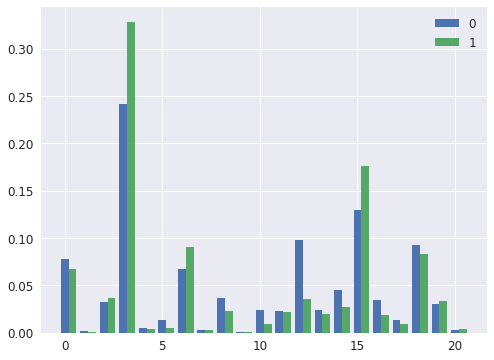

In [102]:
x = np.arange(0,len(no))
plt.figure(figsize=(8,6))
plt.bar(x, no, width=0.4, label='0')
plt.bar(x+0.4, re, width=0.4, label = '1')
plt.legend();
#plt.xticks(np.arange(0,len(no)),department_df.sort_values('department_id')['department'], rotation=90);

In [103]:
dept_freq = pd.DataFrame(no)
dept_freq.columns = ['no_reordered']
dept_freq = pd.concat([dept_freq, re.to_frame()], axis=1)
dept_freq.rename(columns={'department_id':'reordered'}, inplace=True)

In [104]:
dept_freq['diff'] = dept_freq['reordered']-dept_freq['no_reordered']

In [105]:
dept_freq['dept_bin']=0
dept_freq.loc[(dept_freq['diff']>=0.02), 'dept_bin'] = 2
dept_freq.loc[(dept_freq['diff']<0.02) & (dept_freq['diff']>= 0 ),  'dept_bin'] = 1
dept_freq.loc[(dept_freq['diff']<0) & (dept_freq['diff']>= -0.01 ),  'dept_bin'] = -1
dept_freq.loc[(dept_freq['diff']<-0.01) & (dept_freq['diff']>= -0.02 ),  'dept_bin'] = -2
dept_freq.loc[(dept_freq['diff']<-0.02),  'dept_bin'] = -3

In [106]:
dept_map= dept_freq['dept_bin']

In [107]:
df_dept['product_dept_bin'] = df_dept['department_id'].map(dept_map)

In [108]:
df_dept.drop(columns='department_id', inplace=True)

In [110]:
dept_map.value_counts()

-1    8
-2    5
 1    4
 2    3
-3    1
Name: dept_bin, dtype: int64

In [109]:
# with open('processing/0806_1pm_df_dept.pkl', 'wb') as f:
#     pickle.dump(df_dept, f)

Bin aisle

In [111]:
no = df_dept.loc[df_dept['reordered']==0,'aisle_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==0,'aisle_id'].count()
re = df_dept.loc[df_dept['reordered']==1,'aisle_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==1,'aisle_id'].count()

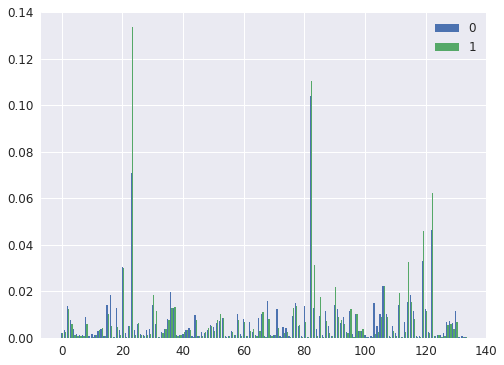

In [112]:
x1 = np.arange(0,len(no))
x2 = np.arange(0, len(re))
plt.figure(figsize=(8,6))
plt.bar(x1, no, width=0.4, label='0')
plt.bar(x2+0.4, re, width=0.4, label = '1')
plt.legend();

In [113]:
aisle_freq  = pd.DataFrame(no)
aisle_freq.columns=['no_reorder']
aisle_freq = pd.merge(aisle_freq, re.to_frame(), left_index=True, right_index=True, how='outer')

In [114]:
aisle_freq.fillna(0, inplace=True)
aisle_freq.rename(columns={'aisle_id':'reordered'}, inplace =True)
aisle_freq['diff'] = aisle_freq['reordered'] - aisle_freq['no_reorder']

In [115]:
aisle_freq['product_aisle_bin'] = 0

aisle_freq.loc[aisle_freq['diff']>=0.001, 'product_aisle_bin'] = 2

aisle_freq.loc[aisle_freq['diff']<=-0.001, 'product_aisle_bin'] = -2

aisle_freq.loc[(aisle_freq['diff']<0.001) & (aisle_freq['diff']>=0), 'product_aisle_bin'] = 1

aisle_freq.loc[(aisle_freq['diff']>-0.001) & (aisle_freq['diff']<0), 'product_aisle_bin'] = -1

In [116]:
aisle_freq.product_aisle_bin.value_counts()

-1    54
-2    46
 1    18
 2    16
Name: product_aisle_bin, dtype: int64

In [117]:
aisle_map = aisle_freq['product_aisle_bin']

In [49]:
# maps = (dept_map, aisle_map)  #indices are the id
# with open('processing/0806_1pm_maps,pkl', 'wb') as f:
#     pickle.dump(maps, f)

In [118]:
df_aisle=df_dept.copy()

In [119]:
df_aisle['product_aisle_bin'] = df_aisle['aisle_id'].map(aisle_map)
df_aisle.drop(columns='aisle_id', inplace=True)

In [120]:
# with open('processing/0806_1pm_df_aisle.pkl', 'wb') as f:
#     pickle.dump(df_aisle, f)

Bin hour of day in the current order

In [4]:
with open('processing/0806_1pm_df_aisle.pkl', 'rb') as f:
    df_aisle = pickle.load(f)

In [5]:
no = df_aisle.loc[df_aisle['reordered']==0,'order_hour_of_day'].value_counts().sort_index()/\
df_aisle.loc[df_aisle['reordered']==0,'order_hour_of_day'].count()
re =df_aisle.loc[df_aisle['reordered']==1,'order_hour_of_day'].value_counts().sort_index()/\
df_aisle.loc[df_aisle['reordered']==1,'order_hour_of_day'].count()

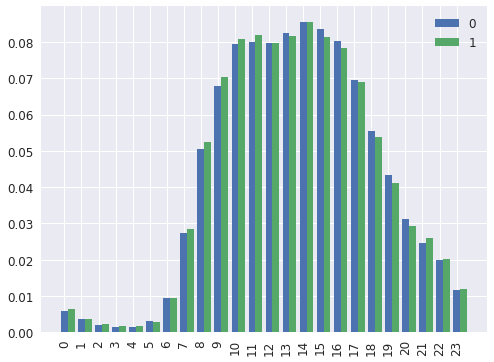

In [6]:
x1=np.arange(len(no))
x2= np.arange(len(re))
plt.figure(figsize=(8,6))
plt.bar(x1, no, width=0.4, label='0')
plt.bar(x2+0.4, re, width=0.4, label = '1')
plt.legend();
plt.xticks(np.arange(0,len(no)),no.index, rotation=90);

In [7]:
product_hod_freq = pd.DataFrame(no)
product_hod_freq.columns=['no_reorder']
product_hod_freq = pd.concat([product_hod_freq, re.to_frame()], axis=1)
product_hod_freq.rename(columns={'order_hour_of_day':'reordered'}, inplace=True)
product_hod_freq['diff'] = product_hod_freq['reordered'] - product_hod_freq['no_reorder']

In [8]:
product_hod_freq['user_current_hod_bin'] = 0
product_hod_freq.loc[(product_hod_freq['diff']>=0), 'user_current_hod_bin']=1
product_hod_freq.loc[(product_hod_freq['diff']<0), 'user_current_hod_bin']=-1

In [126]:
df_hod= df_aisle.copy()

In [9]:
product_hod_freq['user_current_hod_bin'].describe()

count    24.000000
mean      0.250000
std       0.989071
min      -1.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: user_current_hod_bin, dtype: float64

In [10]:
product_hod_freq['user_current_hod_bin'].value_counts()

 1    15
-1     9
Name: user_current_hod_bin, dtype: int64

In [11]:
prod_hod_map = product_hod_freq['user_current_hod_bin']

In [12]:
with open('processing/0806_5pm_product_hod_map.pkl', 'wb') as f:
    pickle.dump(prod_hod_map, f)

In [128]:
df_hod['current_order_hod'] = (df_hod['order_hour_of_day']
                               .map(product_hod_freq['user_current_hod_bin']))

In [129]:
df_hod.drop(columns='order_hour_of_day', inplace=True)

In [130]:
df_hod.shape

(7685556, 29)

Final training data set df_hod.

In [131]:
with open('processing/0806_1pm_df_hod.pkl', 'wb') as f:
    pickle.dump(df_hod, f)